In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys
import os.path

In [2]:
#parameter values
Kcam = 0.055 #um, Equilibrium dissociation constant of CCaMK3Ca2+(CaM4Ca2+) complex
K_dotcam = 0.005 #um, Equilibrium dissociation constant of CCaMKP3Ca2+(CaM4Ca2+) complex
k_star_off = 0.1 #-s, Dissociation rate constant of CaM for CCaMK3Ca2+ at basal Ca2+ level
k_off = 0.0001 #-s, Dissociation rate constant of CaM for CCaMK3Ca2+ at Ca2+ spiking amplitude
k_on = 0.00182 #um-1 s-1, Association rate constant of CaM for CCaMK3Ca2+ ( koff /KCaM) at Ca2+ spiking  amplitude
k_pstar_off = 0.1 # -s, Dissociation rate constant of CaM for CCaMKP3Ca2+ at basal Ca2+ level
k_p_off = 0.0001 #s-1, Dissociation rate constant of CaM for CCaMKP3Ca2+ at Ca2+ spiking amplitude
k_p_on = 0.0182 #um-1 s-1,Association rate constant of CaM for CCaMKP3Ca2+ ( koff  p /K'CaM) at Ca2+  spiking amplitude
Kck1 = 0.200 #um, Dissociation constant of CCaMK EF-hand 1 for Ca2+
Kck2 = 0.200 #um, Dissociation constant of CCaMK EF-hand 2 for Ca2+
Kck3 = 0.020 #um, Dissociation constant of CCaMK EF-hand 3 for Ca2+
Kcam1 = 15 #um, Dissociation constant for N-terminal CaM EF-hands for Ca2+
Kcam2 = 1 #um, Dissociation constant for NC-terminal CaM EF-hands for Ca2+
k1 = 0.0015 #uM-1s-1,rate constant for CCaMK autophosphorylation with Ca2+-saturated CCaMK  as kinase
k2 = 0.7250 #uM-1s-1,rate constant for CCaMK autophosphorylation with Ca2+-saturated Thr-271  phosphorylated CCaMK as kinase
k_dp = 0.001 #s-1, CCaMK dephosphorylation rate
k_cdp = 0.001 # s-1, CCaMK dephosphorylation rate in presence of CaM
C = 10 #um, Total CaM concentration
T = 0.1 #um, Total CCaMK concentration; however, assay conc used is 0.3uM
k_cy_p = 0.15 #um -1, s-1,Target substrate phosphorylation rate
k_cy_dp = 0.001 #s-1, Target substrate dephosphorylation rate
ac = 0.01 # Kinase activity factor
x0 = 0.014 #uM, initial x1 value at time = 0

sign_int = 100 #s, Time Period and amplitude of the sinosoidal Ca2+ signal
amplitude = 0.7 #um, Time Period and amplitude of the sinosoidal Ca2+ signal
basal_Ca = 0.15 #um, Basal Ca2+ concentration; however, assay conc used is 0.1mM

#setting pre-requisite functions

#Pck = probability of CCaMK EF hands being saturated.
#Unsaturated CCaMK given by 1 - Pck
def Pck_eq(c_conc = basal_Ca):
    return (c_conc/(Kck1+c_conc))*(c_conc/(Kck2+c_conc))*(c_conc/(Kck3+c_conc))
Pck = Pck_eq()

def Pcam_eq(c_conc = basal_Ca):
    return (c_conc/(Kcam1+c_conc))*(c_conc/(Kcam2+c_conc))
Pcam = Pcam_eq()

time = np.linspace(0,100,500)

In [57]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

def coupled_system(y,t,title):
    x1,x2,x3,x4 = y
    c2_conc = conc_dx(150,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    filepath = "/Users/guf24vol/Documents/training/training/ode_cal/" + f"{title}.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a")
    print(f"{c2_conc},{Pck},{Pcam},{t}")
    sys.stdout = original
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt]

y0 = [0.014,0.0,0.0,0.0] #initial values for x1,x2,x3,x4
# solution = odeint(coupled_system,y0,time)

solution = odeint(func = coupled_system,y0 = y0,t = time,args = ('odeint_1',))
#huh!
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})

odecal_df = pd.read_csv("ode_cal/odeint_1.txt", header=0, names = ["c2_conc", "Pck", "Pcam","Time"])



/var/folders/d1/t36jr2g51dl5124ky8htph_r0000gq/T/ipykernel_52195/1100890613.py:27: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(func = coupled_system,y0 = y0,t = time,args = ('odeint_1',))


Text(0.5, 0.98, 'Pck, Pcam, and C2 Conc derived over time')

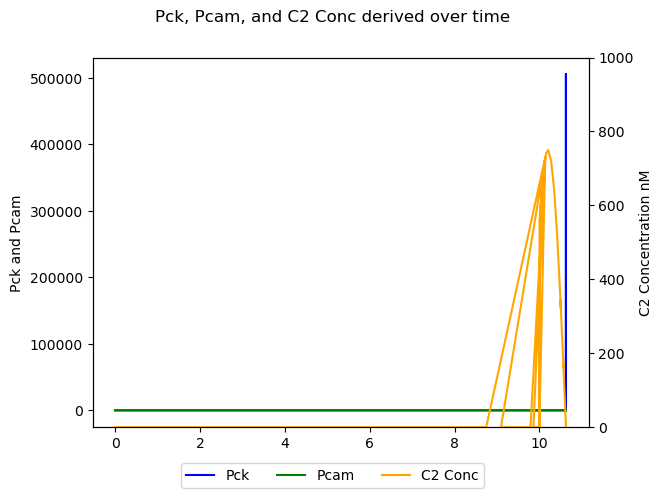

In [56]:
fig, ax1 = plt.subplots()
ax1.plot(odecal_df['Time'],odecal_df['Pck'], label = 'Pck', color = 'blue')
ax1.plot(odecal_df['Time'],odecal_df['Pcam'], label = 'Pcam', color = 'green')
ax1.set_ylabel("Pck and Pcam")
ax2 = ax1.twinx() 
ax2.plot(odecal_df['Time'],odecal_df['c2_conc'], label = 'C2 Conc', color = 'orange')
ax2.set_ylabel("C2 Concentration nM")
ax2.set_ylim(0,1000)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05),
          ncol=3, fancybox=True)
fig.suptitle("Pck, Pcam, and C2 Conc derived over time")

In [ ]:
# def c2_conc(c0,t):
#     period = 100
#     freq = (2*np.pi)/(period)
#     amplitude = 0.700 um
#     conc = 270 * np.sin(freq*time) + 420
#     return c2_conc

def conc_dx(c0,t):
    if t > 10 and t < 40.615:
        period = 1.7
        freq = (2*np.pi)/(period)
        conc = 900*np.cos(t*freq)
    else:
        conc = 0
    filepath = "/Users/guf24vol/Documents/training/training/ode_cal/testing.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a")
    print(f"{t},{conc}")
    sys.stdout = original
    return conc

test = pd.DataFrame(odeint(conc_dx, 150, time))
test_wtime = pd.read_csv("/Users/guf24vol/Documents/training/training/ode_cal/testing.txt",header=0,names=['time','conc'])

fig,ax = plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot(test_wtime['time'],test_wtime['conc'])
plt.subplot(2,1,2)
plt.plot(time,test[0])

#so, this evidences that the variables within odeint act differently to those it finally outputs. and so, i can't believe anything it tells me about Pck, etc.

Text(0.5, 1.0, "i've made a postmodern graph")

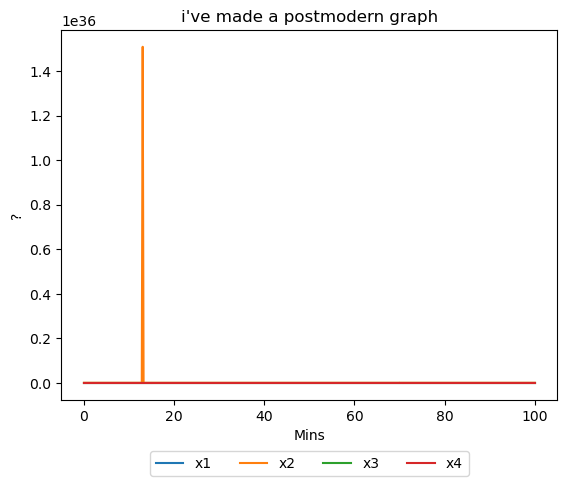

In [41]:
plt.plot(time,solution_df['x1'], label = 'x1')
plt.plot(time,solution_df['x2'], label = 'x2')
plt.plot(time,solution_df['x3'], label = 'x3')
plt.plot(time,solution_df['x4'], label = 'x4')
plt.xlabel('Mins')
plt.ylabel('?')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, fancybox=True)
plt.title("i've made a postmodern graph")


so, the above doesn't work, does it? I want to make it output Pck, Pcam, and time then. This also requires an expanded y0 then.

In [4]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

def coupled_system2(y,t):
    ref_t = t
    x1,x2,x3,x4,c2_conc,Pck,Pcam,ref_t = y #as we see, c2_conc,Pck,Pcam,and ref_t's values are all immediatly changed below this, but this means they can be output without a fuss.
    c2_conc = conc_dx(150,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt,c2_conc,Pck,Pcam,ref_t]

y0 = [0.014,0.0,0.0,0.0,0.0,0.0,0.0,0.0] #initial values for x1,x2,x3,x4
# solution = odeint(coupled_system,y0,time)

solution = odeint(func = coupled_system2,y0 = y0,t = time)
#huh!
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4', 4:'c2_conc',5:'Pck',6:'Pcam',7:'ref_t'})



 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062500601252D+02   r2 =  0.3793864477403D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062500601252D+02   r2 =  0.3793864477403D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062500601252D+02   r2 =  0.7587728954807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062500601252D+02   r2 =  0.7587728954807D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/d1/t36jr2g51dl5124ky8htph_r0000gq/T/ipykernel_62468/1627321505.py:23: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(func = coupled_system2,y0 = y0,t = time)


well, that doesn't bloody work, does it?

In [9]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

def coupled_system2(y,t):
    x1,x2,x3,x4,c0 = y #as we see, c2_conc,Pck,Pcam,and ref_t's values are all immediatly changed below this, but this means they can be output without a fuss.
    c2_conc = conc_dx(c0,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt,c2_conc]

y0 = [0.014,0.0,0.0,0.0,150] #initial values for x1,x2,x3,x4
# solution = odeint(coupled_system,y0,time)

solution = odeint(func = coupled_system2,y0 = y0,t = time, full_output = 1)
#huh!
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4', 4:'c2_conc'})

/var/folders/d1/t36jr2g51dl5124ky8htph_r0000gq/T/ipykernel_62468/746259388.py:22: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(func = coupled_system2,y0 = y0,t = time, full_output = 1)


AttributeError: 'dict' object has no attribute 'dtype'

Text(0.5, 0.98, "i've made a postmodern graph")

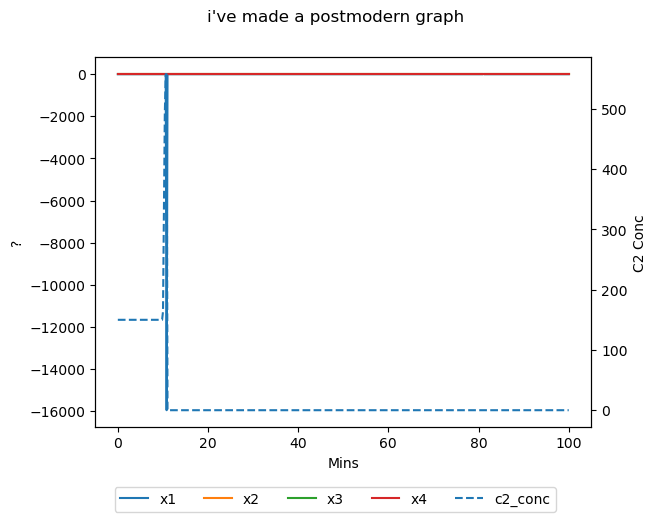

In [19]:
fig,ax1 = plt.subplots()
ax1.plot(time,solution_df['x1'], label = 'x1')
ax1.plot(time,solution_df['x2'], label = 'x2')
ax1.plot(time,solution_df['x3'], label = 'x3')
ax1.plot(time,solution_df['x4'], label = 'x4')
ax1.set_xlabel('Mins')
ax1.set_ylabel('?')

ax2 = plt.twinx(ax1)
ax2.plot(time,solution_df['c2_conc'], label = 'c2_conc',ls="--")
ax2.set_ylabel('C2 Conc')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=5, fancybox=True)
fig.suptitle("i've made a postmodern graph")

this is utterly infuritating, but it must be something wrong with the equations?!